# HW1: Frame-Level Speech Recognition

In this homework, you will be working with MFCC data consisting of 28 features at each time step/frame. Your model should be able to recognize the phoneme occured in that frame.

# Seed
Fix seed for NumPy and PyTorch to achieve effective hyper-parameter tuning.

In [357]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed(23)

# Dataset Description

Let's start by understanding the dataset for this homework.

Our data consists of 3 folders (train-clean-100, dev-clean and test-clean). The training and validation datasets (train-clean-100 and dev-clean) each contain 2 subfolders (mfcc and transcript). The 'mfcc' subfolder contains mel spectrograms (explained below and in writeup), while the 'transcript' subfolder contains their corresponding transcripts. However, the test dataset (test-clean) contains only the 'mfcc' subfolder without the corresponding transcripts, which will later be predicted by your model.


## 1. Audio Representation.
The 'mfcc' subfolders contain many `*.npy` files of mel spectrograms. .npy files are used to store numpy arrays.

Each .npy file represents a short speech recording. For example, one recording might be someone saying, "This is the age of AI." This recording is converted into a mel spectrogram, which is used to represent all forms of audio signals in a computer. Such representation is important in signal and speech processing tasks, especially in machine learning.

Compared to raw audio, mel spectrograms are better for speech processing because they capture both the timing and the frequencies of the sound. At each moment in time, they show which frequencies are present in the sound. This makes it easier for computers to understand and process speech.

When converting raw audio to spectrograms, you do not process the whole audio at once. Instead, you process small frames at a time as you stride over the entire audio length. This means that if you have an audio file of 100 seconds, you may decide to process 10 seconds at a time, striding by one second. In this case, the frame size is 10 seconds. The frame size and the number of timesteps (seconds, milliseconds, etc.) depend on individual choice.

When processing each frame, you extract a number of features that represent that frame's audio. For instance, in the audio recording of "This is the age of AI," the frame corresponding to "AI" will have features that represent how "AI" is pronounced, the vocal tract, and the effect of the environment in which it was recorded. For clarity, when we say features, you should think of columns. One feature/column may have information about the gender of the person who made the speech. Another may have information about the age of the person. Another may have information about the environment where the speech was recorded. Basically, the main properties that make up a speech are encoded in those features, which combine in some way to make the audio.

Since we want to recognize the word as it was pronounced despite the environment and other variabilities, we usually normalize to eliminate or minimize such effects.

Our spectrograms contain 28 features. Essentially, the number of features may be different. They may depend on how the raw audio data was converted into mel spectrograms.

## 2. Transcripts
Remember where we mentioned frames? Well, in our dataset, audio frames have corresponding target transcripts. For instance the abbreviation "AI", in our example above, if present in the recordings, will have transcripts: /eɪ aɪ/. This means that you will have two frames one for  /eɪ/ and another for /aɪ/.

This way of representing pronounciation in text form is called ***phonetic transcription***, "the conversion of spoken words the way they are pronounced instead of how they are written"[[link]](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://krisp.ai/blog/phonetic-transcription/%23:~:text%3Dphonetic%2520transcriptions%2520done.-,What%2520are%2520Phonetic%2520Transcriptions%253F,verbatim%2520to%2520intelligent%2520verbatim%2520transcriptions.&ved=2ahUKEwiV6LO6hrSHAxUKSvEDHcvwAAsQFnoECB0QAw&usg=AOvVaw0VqoWceOzdVwe-AvdyyWqJ). In this case letters 'A' and 'I' are pronounce /eɪ/ and /aɪ/, respectively. Both letters in different words may be pronounced differently.

The produced representation of the speech is referred to as phonemes. Various .npy files that contain recordings of the sentence **"This is the age of AI."** would map to **"/ðɪs ɪz ðə eɪdʒ əv eɪ aɪ/."** The phonemes representation for **Chelsea sucks** would be **/ˈtʃɛl.si sʌks/**

Going inside the .npy files. Each .npy file contains vectors which have 28 features/dimensions/columns. The number of vectors in the file corresponds to the number of frames in the recording. And each single frame has a corresponding phoneme in the transcript.

For instance the .npy file for "This is the age of AI" --> "/ðɪs ɪz ðə eɪdʒ əv eɪ aɪ/" might have 13 frames (13 vectors):

- /ðɪs/ has 3 phonemes: /ð/, /ɪ/, /s/  
- /ɪz/ has 2 phonemes: /ɪ/, /z/
- /ðə/ has 2 phonemes: /ð/, /ə/
- /eɪdʒ/ has 2 phonemes: /eɪ/, /dʒ/
- /əv/ has 2 phonemes: /ə/, /v/
- /eɪ aɪ/ has 2 phonemes: /eɪ/, /aɪ/

**Chelsea sucks** --> **/ˈtʃɛl.si sʌks/** might have 8 frames (8 vectors):

- /ˈtʃɛl.si/ has 4 phonemes: /tʃ/, /ɛ/, /l/, /si/
- /sʌks/ has 4 phonemes: /s/, /ʌ/, /k/, /s/

Note that recordings of different sentences may have different number of frames.

The model you will produce must take a vector of a particular frame and predict the frame's transcript as accurately as possible.

Therefore, the **__getitem__** method of your dataset class must return a 28 dimensional vector of a particular frame and its corresponding phoneme transcript.

This means that, while you are doing your data preprocessing in the **__init__** method, you need stack all vectors from all recordings on top of each other. You must do this for all transcripts as well and remember to ensure the correspondance between frames and their phoneme mapping is maintained.

For our dataset of two samples above, if you stack the recordings together, you get:


| Frame | Feature 1 | Feature 2 | ... | Feature 28 | Phoneme |
|-------|-----------|-----------|-----|------------|---------|
| 0     | v0_1      | v0_2      | ... | v0_28      | /ð/     |
| 1     | v1_1      | v1_2      | ... | v1_28      | /ɪ/     |
| 2     | v2_1      | v2_2      | ... | v2_28      | /s/     |
| 3     | v3_1      | v3_2      | ... | v3_28      | /ɪ/     |
| 4     | v4_1      | v4_2      | ... | v4_28      | /z/     |
| 5     | v5_1      | v5_2      | ... | v5_28      | /ð/     |
| 6     | v6_1      | v6_2      | ... | v6_28      | /ə/     |
| 7     | v7_1      | v7_2      | ... | v7_28      | /eɪ/    |
| 8     | v8_1      | v8_2      | ... | v8_28      | /dʒ/    |
| 9     | v9_1      | v9_2      | ... | v9_28      | /ə/     |
| 10    | v10_1     | v10_2     | ... | v10_28     | /v/     |
| 11    | v11_1     | v11_2     | ... | v11_28     | /eɪ/    |
| 12    | v12_1     | v12_2     | ... | v12_28     | /aɪ/    |
| 13    | v13_1     | v13_2     | ... | v13_28     | /tʃ/    |
| 14    | v14_1     | v14_2     | ... | v14_28     | /ɛ/     |
| 15    | v15_1     | v15_2     | ... | v15_28     | /l/     |
| 16    | v16_1     | v16_2     | ... | v16_28     | /si/     |
| 17    | v17_1     | v17_2     | ... | v17_28     | /s/     |
| 18    | v18_1     | v18_2     | ... | v18_28     | /ʌ/     |
| 19    | v19_1     | v19_2     | ... | v19_28     | /k/     |
| 20    | v20_1     | v20_2     | ... | v20_28     | /s/     |


So, if you pass index 5 to **__getitem__**, you will get back vector v5 (v5_1, v5_2, ..., v5_28) and transcript **/ð/**. Ideally, if you have a well trained model, it should take v5 and return **/ð/**. And the call to **__len__** would return 21 which the training loop would use to go through the whole dataset.

## Context

In the dataset we are using, a few millisecs were used to convert raw audio to mel spectrogram and extract the 28 features.
Since each vector represents only a few millisecs of speech, it may not be sufficient to feed only a single vector into the network at a time. Instead, it may be useful to provide the network with some “context” of size K around each vector in terms of additional vectors from the speech input.

Concretely, a context of size 3 would mean that we provide an input of size (7, 28) to the network - the size 7 can be explained as: the vector to predict the label for, 3 vectors preceding this vector, and 3 vectors following it. It is worth thinking about how you would handle providing context before one of the first K frames of an utterance or after one of the last K frames.

There are several ways to implement this, but you could try the simplest one:
- Concatenating all utterances and padding with K 0-valued vectors before and after the resulting matrix

If you use a context of 3 on the above table, you get the following table:

| Frame | Feature 1 | Feature 2 | ... | Feature 28 | Phoneme | Context Vectors |
|-------|-----------|-----------|-----|------------|---------|----------------|
| 0     | v0_1      | v0_2      | ... | v0_28      | /ð/     | [0, 0, 0, ..., 0] (Padding), [0, 0, 0, ..., 0] (Padding), [0, 0, 0, ..., 0] (Padding), v0, v1, v2, v3 |
| 1     | v1_1      | v1_2      | ... | v1_28      | /ɪ/     | [0, 0, 0, ..., 0] (Padding), [0, 0, 0, ..., 0] (Padding), v0, v1, v2, v3, v4 |
| 2     | v2_1      | v2_2      | ... | v2_28      | /s/     | [0, 0, 0, ..., 0] (Padding), v0, v1, v2, v3, v4, v5 |
| 3     | v3_1      | v3_2      | ... | v3_28      | /ɪ/     | v0, v1, v2, v3, v4, v5, v6 |
| 4     | v4_1      | v4_2      | ... | v4_28      | /z/     | v1, v2, v3, v4, v5, v6, v7 |
| 5     | v5_1      | v5_2      | ... | v5_28      | /ð/     | v2, v3, v4, v5, v6, v7, v8 |
| 6     | v6_1      | v6_2      | ... | v6_28      | /ə/     | v3, v4, v5, v6, v7, v8, v9 |
| 7     | v7_1      | v7_2      | ... | v7_28      | /eɪ/    | v4, v5, v6, v7, v8, v9, v10 |
| 8     | v8_1      | v8_2      | ... | v8_28      | /dʒ/    | v5, v6, v7, v8, v9, v10, v11 |
| 9     | v9_1      | v9_2      | ... | v9_28      | /ə/     | v6, v7, v8, v9, v10, v11, v12 |
| 10    | v10_1     | v10_2     | ... | v10_28     | /v/     | v7, v8, v9, v10, v11, v12, v13 |
| 11    | v11_1     | v11_2     | ... | v11_28     | /eɪ/    | v8, v9, v10, v11, v12, v13, v14 |
| 12    | v12_1     | v12_2     | ... | v12_28     | /aɪ/    | v9, v10, v11, v12, v13, v14, v15 |
| 13    | v13_1     | v13_2     | ... | v13_28     | /tʃ/    | v10, v11, v12, v13, v14, v15, v16 |
| 14    | v14_1     | v14_2     | ... | v14_28     | /ɛ/     | v11, v12, v13, v14, v15, v16, v17 |
| 15    | v15_1     | v15_2     | ... | v15_28     | /l/     | v12, v13, v14, v15, v16, v17, v18 |
| 16    | v16_1     | v16_2     | ... | v16_28     | /s/     | v13, v14, v15, v16, v17, v18, v19 |
| 17    | v17_1     | v17_2     | ... | v17_28     | /i/     | v14, v15, v16, v17, v18, v19, v20 |
| 18    | v18_1     | v18_2     | ... | v18_28     | /s/     | v15, v16, v17, v18, v19, v20, v21 |
| 19    | v19_1     | v19_2     | ... | v19_28     | /ʌ/     | v16, v17, v18, v19, v20, v21, [0, 0, 0, ..., 0] (Padding) |
| 20    | v20_1     | v20_2     | ... | v20_28     | /k/     | v17, v18, v19, v20, v21, [0, 0, 0, ..., 0] (Padding), [0, 0, 0, ..., 0] (Padding) |
| 21    | v21_1     | v21_2     | ... | v21_28     | /s/     | v18, v19, v20, v21, [0, 0, 0, ..., 0] (Padding), [0, 0, 0, ..., 0] (Padding), [0, 0, 0, ..., 0] (Padding) |


Now, if you want to predict the output of vector v5, you won't just pass vector v5 alone. You will concatenate 3 vectors before it and 3 vectors after, which makes it 7 vectors ([v2, v3, v4, v5, v6, v7, v8 ]) . This needs to be reflected in your **__getitem__** method. Meaning it should return an array of shape (7, 28), in this example.

Hence your model is going to be taking a tensor (array) of shape (7, 28) in this example.

# Libraries

In [358]:
# !pip install --upgrade kaggle==1.6.17 --force-reinstall --no-deps 

In [359]:
# !pip install torchsummaryX==1.1.0 wandb --quiet

In [360]:
# !pip install torchaudio --quiet

In [361]:
# !pip install scikit-learn --quiet
# !pip install pandas

In [362]:
import torch
import torch.nn as nn
import numpy as np
from torchsummaryX import summary
import sklearn
import gc
import zipfile
import bisect
import pandas as pd
from tqdm.auto import tqdm
import os
import datetime
import wandb
import yaml
import torchaudio.transforms as tat
import torchaudio
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda:0


# Mount Google Drive

In [363]:
''' If you are using colab, you can import google drive to save model checkpoints in a folder
    If you want to use it, uncomment the two lines below
'''
# from google.colab import drive
# drive.mount('/content/drive')

' If you are using colab, you can import google drive to save model checkpoints in a folder\n    If you want to use it, uncomment the two lines below\n'

In [364]:
### PHONEME LIST
PHONEMES = [
            '[SIL]',   'AA',    'AE',    'AH',    'AO',    'AW',    'AY',
            'B',     'CH',    'D',     'DH',    'EH',    'ER',    'EY',
            'F',     'G',     'HH',    'IH',    'IY',    'JH',    'K',
            'L',     'M',     'N',     'NG',    'OW',    'OY',    'P',
            'R',     'S',     'SH',    'T',     'TH',    'UH',    'UW',
            'V',     'W',     'Y',     'Z',     'ZH',    '[SOS]', '[EOS]']

# Kaggle

This section contains code that helps you install kaggle's API, creating kaggle.json with you username and API key details. Make sure to input those in the given code to ensure you can download data from the competition successfully.

In [365]:
# !unzip hw-1-p-2-data.zip

In [366]:
# !pip install --upgrade kaggle==1.6.17 --force-reinstall --no-deps
# !mkdir /root/.kaggle

# with open("/root/.kaggle/kaggle.json", "w+") as f:
#     # Put your kaggle username & key here
#     f.write('{"username":"","key":""}')

# !chmod 600 /root/.kaggle/kaggle.json

In [367]:
# # commands to download data from kaggle
# !kaggle competitions download -c 11785-spring-25-hw-1-p-2

# # Unzip downloaded data
# !unzip -qo /content/11785-spring-25-hw-1-p-2.zip -d '/content'

# Parameters Configuration

Storing your parameters and hyperparameters in a single configuration dictionary makes it easier to keep track of them during each experiment. It can also be used with weights and biases to log your parameters for each experiment and keep track of them across multiple experiments.

In [368]:
config = {
    'Name': 'Lingyun', # Write your name here
    'subset': 1, # Subset of dataset to use (1.0 == 100% of data)
    'context': 40,
    'archetype': 'cylinder', # Default Values: pyramid, diamond, inverse-pyramid, cylinder
    'activations': 'leakyrelu', # gelu, relu, leakyrelu, softplus, tanh, sigmoid
    'batch_norm': True, 
    'batchnorm_alternate': False, # Whether apply batchnorm to alternate layers
    'learning_rate': 0.001,
    'dropout': 0, # 0-0.5
    'dropout_alternate': True, # Whether apply dropout to alternate layers
    'num_layers': 7, # 2-8
    'optimizers': 'adamw',
    'scheduler': 'cosineanneal', # steplr, reducelronplateau, exponential, cosineanneal
    'epochs': 50,
    'batch_size': 2048, # 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768
    'weight_decay': 0.001, # don't tune this
    'weight_initialization': 'kaiming_uniform', # kaiming_normal, kaiming_uniform, uniform, xavier_normal or xavier_uniform
    'augmentations': 'Both', # Options: ["FreqMask", "TimeMask", "Both", null]
    'freq_mask_param': 4,
    'time_mask_param': 8,
}

In [369]:
config

{'Name': 'Lingyun',
 'subset': 1,
 'context': 40,
 'archetype': 'cylinder',
 'activations': 'leakyrelu',
 'batch_norm': True,
 'batchnorm_alternate': False,
 'learning_rate': 0.001,
 'dropout': 0,
 'dropout_alternate': True,
 'num_layers': 7,
 'optimizers': 'adamw',
 'scheduler': 'cosineanneal',
 'epochs': 50,
 'batch_size': 2048,
 'weight_decay': 0.001,
 'weight_initialization': 'kaiming_uniform',
 'augmentations': 'Both',
 'freq_mask_param': 4,
 'time_mask_param': 8}

# Dataset Class

This section covers the dataset/dataloader class for speech data. You will have to spend time writing code to create this class successfully. We have given you a lot of comments guiding you on what code to write at each stage, from top to bottom of the class. Please try and take your time figuring this out, as it will immensely help in creating dataset/dataloader classes for future homeworks.

Before running the following cells, please take some time to analyse the structure of data. Try loading a single MFCC and its transcipt, print out the shapes and print out the values. Do the transcripts look like phonemes?

In [370]:
import torch.nn.functional as F
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, root, phonemes=PHONEMES, context=0, partition="train-clean-100"):
      self.context = context
      self.phonemes = phonemes
      self.subset = config['subset']
      self.partition = partition

      # TODO: Initialize augmentations. Read the Pytorch torchaudio documentations on timemasking and frequencymasking
      self.freq_masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=config['freq_mask_param'])
      self.time_masking = torchaudio.transforms.TimeMasking(time_mask_param=config['time_mask_param'])

      # Set directories
      self.mfcc_dir = os.path.join(root, partition, 'mfcc')
      self.transcript_dir = os.path.join(root, partition, 'transcript')

      # List files in sorted order
      mfcc_names = sorted(os.listdir(self.mfcc_dir))
      transcript_names = sorted(os.listdir(self.transcript_dir))

      # Compute size of data subset
      subset_size = int(self.subset * len(mfcc_names))
      mfcc_names = mfcc_names[:subset_size]
      transcript_names = transcript_names[:subset_size]
      
      assert len(mfcc_names) == len(transcript_names)

      self.mfccs, self.transcripts = [], []

      for i in tqdm(range(len(mfcc_names))):
          # Load and normalize MFCC
          mfcc = np.load(os.path.join(self.mfcc_dir, mfcc_names[i]))
          mfccs_normalized = (mfcc - np.mean(mfcc, axis=0)) / (np.std(mfcc, axis=0) + 1e-8)
          mfccs_normalized = torch.tensor(mfccs_normalized, dtype=torch.float32)

          # Load and process transcript
          transcript = np.load(os.path.join(self.transcript_dir, transcript_names[i]))
          # print(transcript)
          transcript = transcript[1:-1]  # Remove [SOS] and [EOS]

          # Convert phonemes to indices
          transcript_indices = [self.phonemes.index(p) for p in transcript]
          transcript_indices = torch.tensor(transcript_indices, dtype=torch.int64)

          self.mfccs.append(mfccs_normalized)
          self.transcripts.append(transcript_indices)

      # Concatenate all mfccs and transcripts
      self.mfccs = torch.cat(self.mfccs, dim=0)
      self.transcripts = torch.cat(self.transcripts, dim=0)
      
      self.length = len(self.mfccs)

      # # Add context padding
      padding = (0, 0, self.context, self.context)
      self.mfccs = F.pad(self.mfccs, padding, mode='constant', value=0)

    def __len__(self):
      return self.length

    def __getitem__(self, ind):
      # Get frames with context
      start_idx = ind
      end_idx = ind + 2 * self.context + 1
      frames = self.mfccs[start_idx:end_idx]
      
      phonemes = self.transcripts[ind]
      return frames, phonemes

    def collate_fn(self, batch):
      x, y = zip(*batch)
      x = torch.stack(x, dim=0)

      if "train" in self.partition and np.random.rand() < 0.70:
        x = x.transpose(1, 2)
        x = self.freq_masking(x)
        x = self.time_masking(x)
        x = x.transpose(1, 2)

      return x, torch.tensor(y)


In [371]:
# TODO: Create a test dataset class similar to the previous class but you dont have transcripts for this
# Imp: Read the mfccs in sorted order, do NOT shuffle the data here or in your dataloader.
# IMPORTANT: Load complete test data to use, DO NOT select subset of test data, else you will get errors when submitting on Kaggle.

class AudioTestDataset(torch.utils.data.Dataset):
    def __init__(self, root, context=0, partition="test-clean"):
        self.context = context
        
        # Set test data directory
        self.mfcc_dir = os.path.join(root, partition, 'mfcc')
        
        # List files in sorted order
        self.mfcc_names = sorted(os.listdir(self.mfcc_dir))

        self.mfccs = []

        for mfcc_file in tqdm(self.mfcc_names):
            # Load and normalize MFCC
            mfcc = np.load(os.path.join(self.mfcc_dir, mfcc_file))
            mfccs_normalized = (mfcc - np.mean(mfcc, axis=0)) / (np.std(mfcc, axis=0) + 1e-8)
            mfccs_normalized = torch.tensor(mfccs_normalized, dtype=torch.float32)
            self.mfccs.append(mfccs_normalized)

        # Concatenate all mfccs 
        self.mfccs = torch.cat(self.mfccs, dim=0)
        
        self.length = len(self.mfccs)

        # Add context padding
        padding = (0, 0, self.context, self.context)
        self.mfccs = F.pad(self.mfccs, padding, mode='constant', value=0)

    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        # Get frames with context
        start_idx = ind
        end_idx = ind + 2 * self.context + 1
        frames = self.mfccs[start_idx:end_idx]
        return frames

# Create Datasets

In [372]:
ROOT = "/home/xly/11785/hw1p2/11785-s25-hw1p2" # Define the root directory of the dataset here

# TODO: Create a dataset object using the AudioDataset class for the training data
train_data = AudioDataset(ROOT, context=config['context'], partition="train-clean-100")

# TODO: Create a dataset object using the AudioDataset class for the validation data
val_data = AudioDataset(ROOT, context=config['context'], partition="dev-clean")

# TODO: Create a dataset object using the AudioTestDataset class for the test data
test_data = AudioTestDataset(ROOT, context=config['context'], partition="test-clean")

100%|██████████| 2620/2620 [00:00<00:00, 3208.59it/s]


In [373]:
from collections import Counter

print(len(val_data))
# Find the least common index in val_data.transcripts
# Flatten the list of transcripts
all_transcripts = val_data.transcripts.tolist()

# Count the frequency of each index
transcript_counts = Counter(all_transcripts)

print(transcript_counts)
# Find the least common index
least_common_idx = transcript_counts.most_common()[-1][0]
print("Least common index:", least_common_idx)

1928204
Counter({0: 319908, 3: 123734, 29: 101184, 31: 97390, 23: 94541, 17: 74887, 18: 70861, 21: 65902, 9: 62763, 28: 62686, 12: 54928, 38: 54850, 6: 49332, 2: 49298, 11: 47112, 20: 47016, 22: 44728, 36: 37697, 14: 37562, 10: 37100, 13: 36184, 16: 34813, 27: 34131, 25: 30755, 1: 29688, 4: 29340, 35: 27440, 34: 26691, 7: 23607, 5: 20274, 24: 19327, 30: 17628, 15: 13541, 8: 12644, 37: 9669, 32: 9247, 19: 8730, 33: 6286, 26: 3861, 39: 869})
Least common index: 39


In [374]:
# Define dataloaders for train, val and test datasets
# Dataloaders will yield a batch of frames and phonemes of given batch_size at every iteration
# We shuffle train dataloader but not val & test dataloader. Why?

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    num_workers = 4,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = True,
    collate_fn = train_data.collate_fn
)

val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    num_workers = 0,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False
)

test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    num_workers = 0,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False
)


print("Batch size     : ", config['batch_size'])
print("Context        : ", config['context'])
print("Input size     : ", (2*config['context']+1)*28)
print("Output symbols : ", len(PHONEMES))

print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Validation dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size     :  2048
Context        :  40
Input size     :  2268
Output symbols :  42
Train dataset samples = 36091157, batches = 17623
Validation dataset samples = 1928204, batches = 942
Test dataset samples = 1934138, batches = 945


import matplotlib.pyplot as plt

# Testing code to check if your data loaders are working
for i, data in enumerate(train_loader):
    frames, phoneme = data
    print(frames.shape, phoneme.shape)

    # Visualize sample mfcc to inspect and verify everything is correctly done, especially augmentations
    plt.figure(figsize=(10, 6))
    plt.imshow(frames[0].numpy().T, aspect='auto', origin='lower', cmap='viridis')
    plt.xlabel('Time')
    plt.ylabel('Features')
    plt.title('Feature Representation')
    plt.show()

    break

In [375]:
# Testing code to check if your validation data loaders are working
all = []
for i, data in enumerate(val_loader):
    frames, phoneme = data
    all.append(phoneme)
    break

# Network Architecture


This section defines your network architecture for the homework. We have given you a sample architecture that can easily clear the very low cutoff for the early submission deadline.

# This architecture will make you cross the very low cutoff
# However, you need to run a lot of experiments to cross the medium or high cutoff
'''Python
class Network(nn.Module):
    def __init__(self, input_size, output_size, config=None):
        super(Network, self).__init__()

        if config:
            self.model = 
        else:
            self.model = nn.Sequential(
                torch.nn.Linear(input_size, 512),
                torch.nn.ReLU(),
                torch.nn.Linear(512, output_size)
            )

        if config['weight_initialization'] is not None:
            self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                if config["weight_initialization"] == "xavier_normal":
                    torch.nn.init.xavier_normal_(m.weight)
                elif config["weight_initialization"] == "xavier_uniform":
                    torch.nn.init.xavier_uniform_(m.weight)
                elif config["weight_initialization"] == "kaiming_normal":
                    torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                elif config["weight_initialization"] == "kaiming_uniform":
                    torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                elif config["weight_initialization"] == "uniform":
                    torch.nn.init.uniform_(m.weight)
                else:
                    raise ValueError("Invalid weight_initialization value")

                # Initialize bias to 0
                m.bias.data.fill_(0)


    def forward(self, x):

        # Flatten to a 1D vector for each data point
        x = torch.flatten(x, start_dim=1)  # Keeps batch size, flattens the rest

        return self.model(x)
'''

In [376]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, config):
        super(Network, self).__init__()
        
        self.config = config
        layers = []
        
        # Define architecture sizes based on archetype
        if config['archetype'].lower() == 'cylinder':
            hidden_sizes = [1600] * (config.get('num_layers', 4))
        elif config['archetype'].lower() == 'pyramid':
            hidden_sizes = [int(512/(2**i)) for i in range(config.get('num_layers', 4))]
        elif config['archetype'].lower() == 'inverse-pyramid':
            hidden_sizes = [int(64*(2**i)) for i in range(config.get('num_layers', 4))]
        elif config['archetype'].lower() == 'diamond':
            num_layers = config.get('num_layers', 4)
            mid_point = num_layers // 2
            first_half = [int(352*(2**i)) for i in range(mid_point)]
            second_half = [int(352*(2**(mid_point-i-1))) for i in range(num_layers - mid_point)]
            hidden_sizes = first_half + second_half
        
        # Get activation function
        activation_map = {
            'relu': nn.ReLU(),
            'leakyrelu': nn.LeakyReLU(),
            'gelu': nn.GELU(),
            'softplus': nn.Softplus(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid()
        }
        activation = activation_map.get(config['activations'].lower(), nn.ReLU())
        
        # Build layers
        current_size = input_size
        for i, hidden_size in enumerate(hidden_sizes): # Enumerate the hidden layers
            # Add linear layer
            layers.append(nn.Linear(current_size, hidden_size))
            
            # Add BatchNorm if specified
            if config.get('batch_norm', 'No Layer') != 'No Layer':
                if (i != len(hidden_sizes)-1) and (i % 2 ==0 or config.get('batchnorm_alternate', False) is False):
                    layers.append(nn.BatchNorm1d(hidden_size))
            
            # Add activation
            layers.append(activation)
            
            # Add dropout if specified
            if config.get('dropout', 0) > 0:
                if i % 2 == 0 or config.get('dropout_alternate', False) is False:
                    layers.append(nn.Dropout(config['dropout']))
            
            current_size = hidden_size
        
        # Add output layer
        layers.append(nn.Linear(current_size, output_size))
        
        self.model = nn.Sequential(*layers)
        
        # Initialize weights if specified
        if config['weight_initialization'] is not None:
            self.initialize_weights()
    
    def initialize_weights(self):
        for m in self.model.modules():
            if isinstance(m, nn.Linear):
                if self.config['weight_initialization'].lower() == 'xavier_uniform':
                    nn.init.xavier_uniform_(m.weight)
                elif self.config['weight_initialization'].lower() == 'xavier_normal':
                    nn.init.xavier_normal_(m.weight)
                elif self.config['weight_initialization'].lower() == 'kaiming_uniform':
                    nn.init.kaiming_uniform_(m.weight)
                elif self.config['weight_initialization'].lower() == 'kaiming_normal':
                    nn.init.kaiming_normal_(m.weight)
                elif self.config['weight_initialization'].lower() == 'uniform':
                    nn.init.uniform_(m.weight)
                    
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        return self.model(x)

# Example training setup
def get_optimizer(model, config):
    optimizer_map = {
        'sgd': torch.optim.SGD,
        'adam': torch.optim.Adam,
        'adamw': torch.optim.AdamW,
        'rmsprop': torch.optim.RMSprop,
        'nesterov': lambda params, lr: torch.optim.SGD(params, lr, momentum=0.9, nesterov=True)
    }
    optimizer_class = optimizer_map.get(config['optimizers'].lower(), torch.optim.Adam)
    return optimizer_class(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=config['weight_decay']
    )

def get_scheduler(optimizer, config):
    scheduler_map = {
        'steplr': lambda: torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1),
        'reducelronplateau': lambda: torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=4, verbose=True),
        'exponential': lambda: torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9),
        'cosineanneal': lambda: torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
    }
    
    scheduler_fn = scheduler_map.get(config['scheduler'].lower())
    return scheduler_fn() if scheduler_fn else None

# Define Model, Loss Function and Optimizer

Here we define the model, loss function, optimizer and optionally a learning rate scheduler.

In [377]:
INPUT_SIZE  = (2*config['context'] + 1) * 28 # Why is this the case?
model       = Network(INPUT_SIZE, len(train_data.phonemes), config=config).to(device)
summary(model, frames.to(device))
# Check number of parameters of your network
# Remember, you are limited to 20 million parameters for HW1 (including ensembles)

----------------------------------------------------------------------------------------------------
Layer                   Kernel Shape         Output Shape         # Params (K)      # Mult-Adds (M)
0_Linear                [2268, 1600]         [2048, 1600]             3,630.40                 3.63
1_BatchNorm1d                 [1600]         [2048, 1600]                 3.20                 0.00
2_LeakyReLU                        -         [2048, 1600]                    -                    -
3_Linear                [1600, 1600]         [2048, 1600]             2,561.60                 2.56
4_BatchNorm1d                 [1600]         [2048, 1600]                 3.20                 0.00
5_LeakyReLU                        -         [2048, 1600]                    -                    -
6_Linear                [1600, 1600]         [2048, 1600]             2,561.60                 2.56
7_BatchNorm1d                 [1600]         [2048, 1600]                 3.20                 0.00

# Define Model, Loss Function and Optimizer

Here we define the model, loss function, optimizer and optionally a learning rate scheduler.

In [378]:
criterion = torch.nn.CrossEntropyLoss() # Defining Loss function.
# We use CE because the task is multi-class classification

# Choose an appropriate optimizer of your choice
# optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'])
optimizer = get_optimizer(model, config)

# Recommended : Define Scheduler for Learning Rate,
# including but not limited to StepLR, MultiStep, CosineAnnealing, CosineAnnealingWithWarmRestarts, ReduceLROnPlateau, etc.
# You can refer to Pytorch documentation for more information on how to use them.
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
scheduler = get_scheduler(optimizer, config)

# Is your training time very high?
# Look into mixed precision training if your GPU (Tesla T4, V100, etc) can make use of it
# Refer - https://pytorch.org/docs/stable/notes/amp_examples.html
# Mixed Precision Training with AMP for speedup
scaler = torch.amp.GradScaler(device, enabled=True)

# Training and Validation Functions

This section covers the training, and validation functions for each epoch of running your experiment with a given model architecture. The code has been provided to you, but we recommend going through the comments to understand the workflow to enable you to write these loops for future HWs.

In [379]:
# CLEAR RAM!!
torch.cuda.empty_cache()
gc.collect()

708

In [380]:
def train(model, dataloader, optimizer, criterion):

    model.train()
    tloss, tacc = 0, 0 # Monitoring loss and accuracy
    batch_bar   = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    for i, (frames, phonemes) in enumerate(dataloader):

        ### Initialize Gradients
        optimizer.zero_grad()

        frames      = frames.to(device)
        phonemes    = phonemes.to(device)

        with torch.autocast(device_type=device, dtype=torch.float16):
            ### Forward Propagation
            logits  = model(frames)

            ### Loss Calculation
            loss    = criterion(logits, phonemes)

        ### Backward Propagation
        scaler.scale(loss).backward()

        # OPTIONAL: You can add gradient clipping here, if you face issues of exploding gradients

        ### Gradient Descent
        scaler.step(optimizer)
        scaler.update()

        tloss   += loss.item()
        tacc    += torch.sum(torch.argmax(logits, dim= 1) == phonemes).item()/logits.shape[0]

        batch_bar.set_postfix(loss="{:.04f}".format(float(tloss / (i + 1))),
                              acc="{:.04f}%".format(float(tacc*100 / (i + 1))))
        batch_bar.update()

        ### Release memory
        del frames, phonemes, logits
        torch.cuda.empty_cache()


    batch_bar.close()
    tloss   /= len(train_loader)
    tacc    /= len(train_loader)


    return tloss, tacc

In [381]:
def eval(model, dataloader):

    model.eval() # set model in evaluation mode
    vloss, vacc = 0, 0 # Monitoring loss and accuracy
    batch_bar   = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    for i, (frames, phonemes) in enumerate(dataloader):

        ### Move data to device (ideally GPU)
        frames      = frames.to(device)
        phonemes    = phonemes.to(device)

        # makes sure that there are no gradients computed as we are not training the model now
        with torch.inference_mode():
            ### Forward Propagation
            logits  = model(frames)
            ### Loss Calculation
            loss    = criterion(logits, phonemes)

        vloss   += loss.item()
        vacc    += torch.sum(torch.argmax(logits, dim= 1) == phonemes).item()/logits.shape[0]

        # Do you think we need loss.backward() and optimizer.step() here?

        batch_bar.set_postfix(loss="{:.04f}".format(float(vloss / (i + 1))),
                              acc="{:.04f}%".format(float(vacc*100 / (i + 1))))
        batch_bar.update()

        ### Release memory
        del frames, phonemes, logits
        torch.cuda.empty_cache()

    batch_bar.close()
    vloss   /= len(val_loader)
    vacc    /= len(val_loader)

    return vloss, vacc

# Weights and Biases Setup

This section is to enable logging metrics and files with Weights and Biases. Please refer to wandb documentationa and recitation 0 that covers the use of weights and biases for logging, hyperparameter tuning and monitoring your runs for your homeworks. Using this tool makes it very easy to show results when submitting your code and models for homeworks, and also extremely useful for study groups to organize and run ablations under a single team in wandb.

We have written code for you to make use of it out of the box, so that you start using wandb for all your HWs from the beginning.

In [382]:
wandb.login(key="4dd2f46439865db4e3547d39c268ff46468b8ef4") #API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/xly/.netrc


True

# Create your wandb run
run = wandb.init(
    name    = "11785", ### Wandb creates random run names if you skip this field, we recommend you give useful names
    reinit  = True, ### Allows reinitalizing runs when you re-run this cell
    #id     = "", ### Insert specific run id here if you want to resume a previous run
    #resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw1p2", ### Project should be created in your wandb account
    config  = config ### Wandb Config for your run
)

In [383]:
### Save your model architecture as a string with str(model)
model_arch  = str(model)

### Save it in a txt file
arch_file   = open("model_arch.txt", "w")
file_write  = arch_file.write(model_arch)
arch_file.close()

### log it in your wandb run with wandb.save()
# wandb.save('model_arch.txt')

# Experiment

Now, it is time to finally run your ablations! Have fun!

In [384]:
# Iterate over number of epochs to train and evaluate your model
torch.cuda.empty_cache()
gc.collect()
# wandb.watch(model, log="all")
best_acc = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

import time

start_t = time.time()

for epoch in range(config['epochs']):

    print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

    curr_lr                 = float(optimizer.param_groups[0]['lr'])
    train_loss, train_acc   = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc       = eval(model, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print("\tTrain Acc {:.04f}%\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_acc*100, train_loss, curr_lr))
    print("\tVal Acc {:.04f}%\tVal Loss {:.04f}".format(val_acc*100, val_loss))

    ## Log metrics at each epoch in your run
    # Optionally, you can log at each batch inside train/eval functions
    # (explore wandb documentation/wandb recitation)
    '''
    wandb.log({'train_acc': train_acc*100, 'train_loss': train_loss,
               'val_acc': val_acc*100, 'valid_loss': val_loss, 'lr': curr_lr})
    '''
    # If using a scheduler, step the learning rate here, otherwise comment this line
    # Depending on the scheduler in use, you may or may not need to pass in a metric into the step function, so read the docs well
    scheduler.step(val_acc)

    ## Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best
    # Save checkpoint locally
    if val_acc > best_acc:
        best_acc = val_acc
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc
        }
        torch.save(checkpoint, f'best-{device}.pth')
        # wandb.save(f'best.pth')

end_t = time.time()


Epoch 1/50


/home/xly/mambaforge/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


	Train Acc 76.4669%	Train Loss 0.7207	 Learning Rate 0.0010000
	Val Acc 80.6243%	Val Loss 0.5802

Epoch 2/50


	Train Acc 83.2704%	Train Loss 0.4913	 Learning Rate 0.0009994
	Val Acc 82.2340%	Val Loss 0.5353

Epoch 3/50


	Train Acc 85.5922%	Train Loss 0.4145	 Learning Rate 0.0009993
	Val Acc 82.9798%	Val Loss 0.5208

Epoch 4/50


	Train Acc 87.0621%	Train Loss 0.3666	 Learning Rate 0.0009993
	Val Acc 82.9374%	Val Loss 0.5307

Epoch 5/50


	Train Acc 88.0421%	Train Loss 0.3348	 Learning Rate 0.0009993
	Val Acc 83.3377%	Val Loss 0.5302

Epoch 6/50


	Train Acc 88.8088%	Train Loss 0.3106	 Learning Rate 0.0009993
	Val Acc 83.2999%	Val Loss 0.5433

Epoch 7/50


	Train Acc 89.4167%	Train Loss 0.2916	 Learning Rate 0.0009993
	Val Acc 83.3070%	Val Loss 0.5516

Epoch 8/50


	Train Acc 89.9020%	Train Loss 0.2766	 Learning Rate 0.0009993
	Val Acc 83.3673%	Val Loss 0.5633

Epoch 9/50


	Train Acc 90.3251%	Train Loss 0.2639	 Learning Rate 0.0009993
	Val Acc 83.3413%	Val Loss 0.5592

Epoch 10/50


	Train Acc 90.7110%	Train Loss 0.2518	 Learning Rate 0.0009993
	Val Acc 83.2752%	Val Loss 0.5790

Epoch 11/50


	Train Acc 90.9909%	Train Loss 0.2436	 Learning Rate 0.0009993
	Val Acc 83.3823%	Val Loss 0.5851

Epoch 12/50


	Train Acc 91.2943%	Train Loss 0.2346	 Learning Rate 0.0009993
	Val Acc 83.3654%	Val Loss 0.5994

Epoch 13/50


	Train Acc 91.5215%	Train Loss 0.2280	 Learning Rate 0.0009993
	Val Acc 83.2666%	Val Loss 0.6059

Epoch 14/50


	Train Acc 91.7374%	Train Loss 0.2217	 Learning Rate 0.0009993
	Val Acc 83.1727%	Val Loss 0.6030

Epoch 15/50


	Train Acc 91.9055%	Train Loss 0.2169	 Learning Rate 0.0009993
	Val Acc 83.3370%	Val Loss 0.6206

Epoch 16/50


Train:  24%|██▍       | 4207/17623 [00:42<01:49, 121.99it/s, acc=92.3808%, loss=0.2032]

KeyboardInterrupt: 

Train:  24%|██▍       | 4208/17623 [00:58<01:49, 121.99it/s, acc=92.3808%, loss=0.2032]

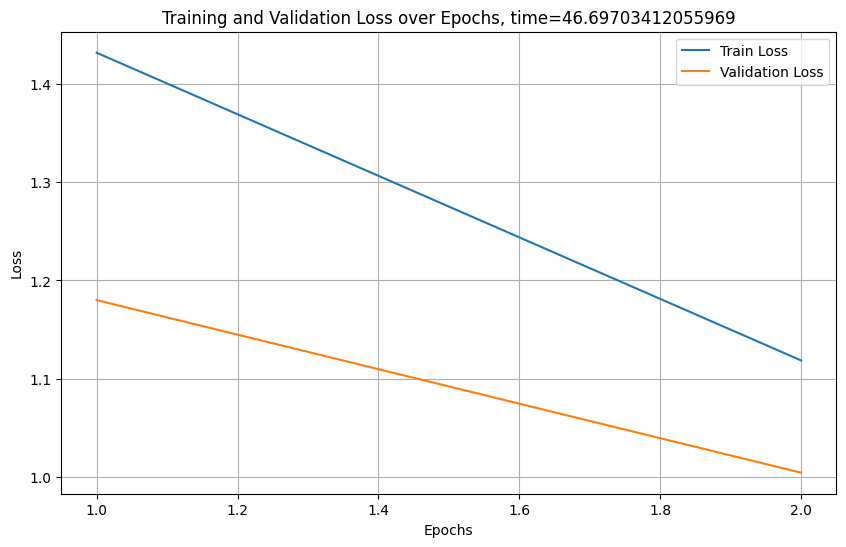

In [123]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss over Epochs, time={end_t-start_t}')
plt.legend()
plt.grid(True)
plt.savefig(f'loss_plot-{device}.png')
# plt.show()

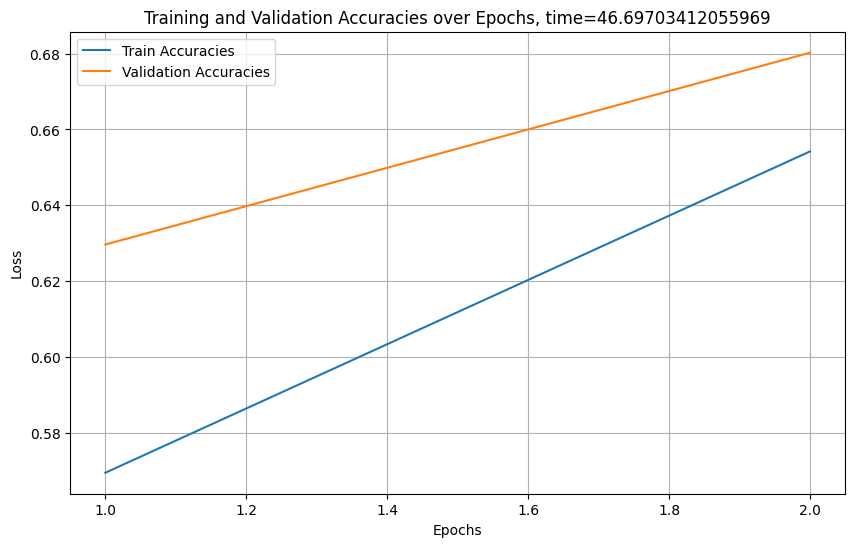

In [188]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracies')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Validation Accuracies over Epochs, time={end_t-start_t}')
plt.legend()
plt.grid(True)
plt.savefig(f'loss_plot-{device}.png')
# plt.show()

# Testing and submission to Kaggle

Before we get to the following code, make sure to see the format of submission given in *sample_submission.csv*. Once you have done so, it is time to fill the following function to complete your inference on test data. Refer the eval function from previous cells to get an idea of how to go about completing this function.

In [189]:
def test(model, test_loader):
    ### What you call for model to perform inference?
    model.eval() # TODO train or eval?

    ### List to store predicted phonemes of test data
    test_predictions = []

    ### Which mode do you need to avoid gradients?
    with torch.no_grad(): # TODO

        for i, mfccs in enumerate(tqdm(test_loader)):

            mfccs   = mfccs.to(device)

            logits  = model(mfccs)

            ### Get most likely predicted phoneme with argmax
            predicted_phonemes = torch.argmax(logits, dim=1).cpu().numpy()

            ### How do you store predicted_phonemes with test_predictions? Hint, look at eval
            # Remember the phonemes were converted to their corresponding integer indices earlier, and the results of the argmax is a list of the indices of the predicted phonemes.
            # So how do you get and store the actual predicted phonemes
            # TODO: Store predicted_phonemes
            test_predictions.extend(predicted_phonemes)

    return test_predictions

In [190]:
checkpoint = torch.load(f'best-{device}.pth')
model.load_state_dict(checkpoint['model_state_dict'])
predictions = test(model, test_loader)

/tmp/ipykernel_2496307/4062863140.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'best-{device}.pth')


100%|██████████| 1889/1889 [00:20<00:00, 93.96it/s]


In [191]:
### Create CSV file with predictions
with open(f"./submission-{device}.csv", "w") as f:
    f.write("id,label\n")
    for i in range(len(predictions)):
        f.write("{},{}\n".format(i, PHONEMES[predictions[i]]))

### Finish your wandb run
run.finish()

In [192]:
### Submit to kaggle competition using kaggle API (Uncomment below to use)
!kaggle competitions submit -c 11785-spring-25-hw-1-p-2 -f /content/submission.csv -m "Test Submission"

### However, its always safer to download the csv file and then upload to kaggle

/bin/bash: line 1: kaggle: command not found
